              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      4509
         1.0       0.76      0.78      0.77      4180
         2.0       0.72      0.72      0.72      3650

    accuracy                           0.76     12339
   macro avg       0.76      0.76      0.76     12339
weighted avg       0.76      0.76      0.76     12339

[[3503  478  528]
 [ 391 3274  515]
 [ 470  553 2627]]


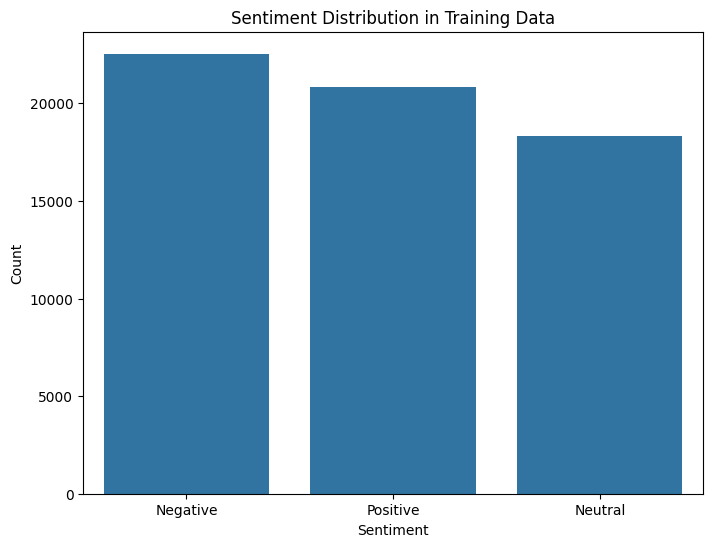

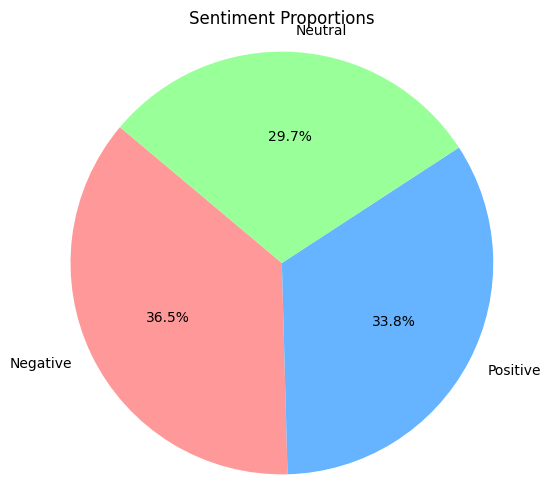

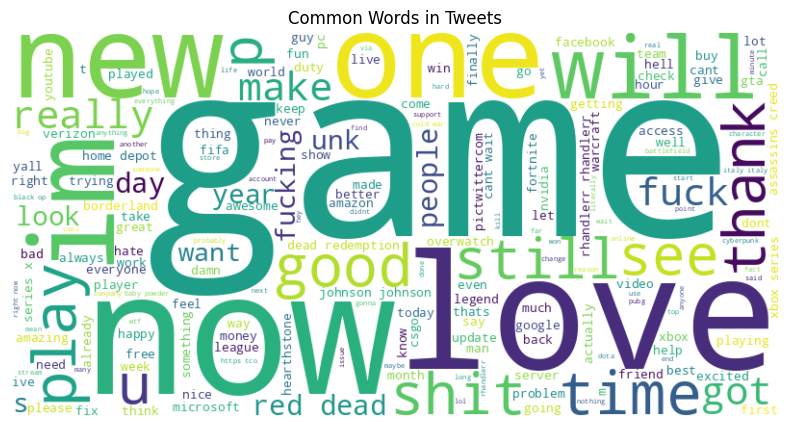

In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load datasets
train_data = pd.read_csv('/content/twitter_training.csv', header=None)
validation_data = pd.read_csv('/content/twitter_validation.csv', header=None)

# Renaming columns
columns = ['ID', 'Entity', 'Sentiment', 'Tweet']
train_data.columns = columns
validation_data.columns = columns

# Selecting relevant columns
train_data = train_data[['Sentiment', 'Tweet']]
validation_data = validation_data[['Sentiment', 'Tweet']]

# Data cleaning function
def clean_text(text):
    if not isinstance(text, str):  # Convert non-string values to an empty string
        return ""
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove special characters
    text = text.lower().strip()
    return text

train_data['Cleaned_Tweet'] = train_data['Tweet'].astype(str).apply(clean_text)
validation_data['Cleaned_Tweet'] = validation_data['Tweet'].astype(str).apply(clean_text)

# Convert labels to numerical values
sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
validation_data['Sentiment'] = validation_data['Sentiment'].map(sentiment_mapping)

# Drop NaN values from training data
train_data = train_data.dropna(subset=['Sentiment'])

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    train_data['Cleaned_Tweet'], train_data['Sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Scale the data
scaler = StandardScaler(with_mean=False)
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

# Train Logistic Regression with more iterations
model = LogisticRegression(max_iter=500)
model.fit(X_train_vec, y_train)

# Predictions
y_pred = model.predict(X_test_vec)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Visualization: Sentiment Distribution
sentiment_counts = train_data['Sentiment'].value_counts().sort_index()
sentiment_labels = ['Negative', 'Positive', 'Neutral']

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_labels, y=sentiment_counts.values)
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Pie chart visualization
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values, labels=sentiment_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Sentiment Proportions')
plt.axis('equal')
plt.show()

# Word Cloud
all_words = ' '.join(train_data['Cleaned_Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Tweets')
plt.show()